In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [3]:
sql="""SELECT 
    Timestamp as TimeCreated,
    Server as Computer,
    EventID,
    -- Convertimos el nivel a String para unificar con las otras tablas
    Level, 
    Source as ProviderName,
    Message,
    'Application' as OriginTable
FROM `tfmunirdataset.DataApplication`

UNION ALL

SELECT 
    Timestamp as TimeCreated,
    Server as Computer,
    EventID,
    Level,
    Source as ProviderName,
    Description as Message, -- Mapeamos Description a Message
    'Security' as OriginTable
FROM `tfmunirdataset.DataSecurity`

UNION ALL

SELECT 
    Timestamp as TimeCreated,
    Server as Computer,
    EventID,
    Level,
    Source as ProviderName,
    Description as Message, -- Mapeamos Description a Message
    'System' as OriginTable
FROM `tfmunirdataset.DataSystem`

UNION ALL

SELECT 
    TimeCreated,
    Computer,
    EventID,
    -- CAST necesario porque en DataLogs 'Level' es INTEGER (Img 5)
    CAST(Level AS STRING) as Level, 
    ProviderName,
    Message,
    'Logs' as OriginTable
FROM `tfmunirdataset.DataLogs`
-- Filtramos por tus servidores de interés según la tesis 
WHERE Computer IN ('Zeus', 'Poseidon', 'Ares')"""

In [4]:
from google.cloud import bigquery

client= bigquery.Client()

In [5]:
data= client.query(sql).to_dataframe()

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2438: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2452: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2466: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [6]:
data.head(10)

,TimeCreated,Computer,EventID,Level,ProviderName,Message,OriginTable
0,2025-11-30 21:59:26.145250+00:00,POSEIDON,6005,Information,EventLog,Event Log service started,System
1,2025-12-01 16:32:19.145250+00:00,POSEIDON,6005,Information,Service Control Manager,Event Log service started,System
2,2025-12-09 17:56:18.145250+00:00,POSEIDON,6005,Information,Microsoft-Windows-Kernel-Power,Event Log service started,System
3,2025-12-02 11:17:42.145250+00:00,POSEIDON,6005,Information,Microsoft-Windows-Kernel-Power,Event Log service started,System
4,2025-12-04 10:56:50.145250+00:00,POSEIDON,6005,Information,EventLog,Event Log service started,System
5,2025-12-10 02:00:21.145250+00:00,POSEIDON,6005,Information,EventLog,Event Log service started,System
6,2025-12-14 16:35:01.145250+00:00,POSEIDON,6005,Information,Service Control Manager,Event Log service started,System
7,2025-12-14 04:49:21.145250+00:00,POSEIDON,6005,Information,Microsoft-Windows-Kernel-Power,Event Log service started,System
8,2025-12-10 19:25:24.145250+00:00,POSEIDON,6005,Information,EventLog,Event Log service started,System
9,2025-12-01 14:41:33.145250+00:00,POSEIDON,6005,Information,Microsoft-Windows-Kernel-Power,Event Log service started,System


In [7]:
# O usando groupby
data.groupby("Level").size()

Level
Error          13461
Information    52019
Warning        14010
dtype: int64

In [8]:
df = data.copy()


level_mapping = {
    'Information': 4,
    'Warning': 3,
    'Error': 2,
    'Critical': 1,
    '4': 4, '3': 3, '2': 2, '1': 1,
    '0': 0 
}

df['Level_Num'] = df['Level'].map(level_mapping)


print("Valores nulos en Level tras mapeo:", df['Level_Num'].isnull().sum())
df = df.dropna(subset=['Level_Num']) 
df['Level_Num'] = df['Level_Num'].astype(int)

print("Distribución de clases:")
print(df['Level_Num'].value_counts())

Valores nulos en Level tras mapeo: 0
Distribución de clases:
Level_Num
4    52019
3    14010
2    13461
Name: count, dtype: int64


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79490 entries, 0 to 79489
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   TimeCreated   79490 non-null  datetime64[ns, UTC]
 1   Computer      79490 non-null  object             
 2   EventID       79490 non-null  Int64              
 3   Level         79490 non-null  object             
 4   ProviderName  79490 non-null  object             
 5   Message       79490 non-null  object             
 6   OriginTable   79490 non-null  object             
dtypes: Int64(1), datetime64[ns, UTC](1), object(5)
memory usage: 4.3+ MB


In [10]:
categorical_vars = []
numeric_discrete_vars = []
numeric_continuous_vars = []
datetime_vars = []
text_vars = []
other_vars = []

for col in data.columns:
    dtype = data[col].dtype

    # --- 1️⃣ Fechas ---
    if pd.api.types.is_datetime64_any_dtype(dtype):
        datetime_vars.append(col)

    # --- 2️⃣ Numéricas ---
    elif pd.api.types.is_numeric_dtype(dtype):
        unique_vals = data[col].nunique(dropna=True)
        total_vals = len(data[col])
        ratio = unique_vals / total_vals

        if ratio < 0.05:
            numeric_discrete_vars.append(col)
        else:
            numeric_continuous_vars.append(col)

    # --- 3️⃣ Texto o categorías ---
    elif pd.api.types.is_object_dtype(dtype):
        avg_len = data[col].astype(str).apply(len).mean()
        unique_ratio = data[col].nunique(dropna=True) / len(data[col])

        if avg_len > 30 or unique_ratio > 0.5:
            text_vars.append(col)
        else:
            categorical_vars.append(col)

    # --- 4️⃣ Otros tipos ---
    else:
        other_vars.append(col)

# --- Mostrar resultados ---
print("🟢 Variables categóricas:", categorical_vars)
print("🔵 Variables numéricas discretas:", numeric_discrete_vars)
print("🟣 Variables numéricas continuas:", numeric_continuous_vars)
print("🟠 Variables de fecha/hora:", datetime_vars)
print("🔴 Variables de texto libre:", text_vars)
print("⚫ Otras variables:", other_vars)

🟢 Variables categóricas: ['Computer', 'Level', 'ProviderName', 'Message', 'OriginTable']
🔵 Variables numéricas discretas: []
🟣 Variables numéricas continuas: ['EventID']
🟠 Variables de fecha/hora: ['TimeCreated']
🔴 Variables de texto libre: []
⚫ Otras variables: []


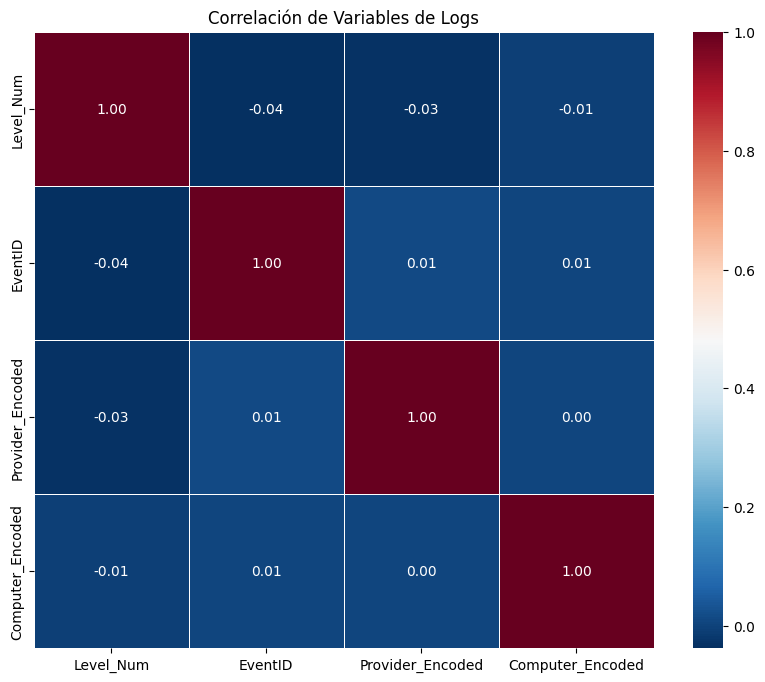

In [11]:
# 1. Crear una copia de los datos para análisis
df_corr = data.copy()

# 2. Convertir 'Level' a Numérico (Paso Crítico según el TFM)
# Asignamos: 1=Critical, 2=Error, 3=Warning, 4=Information
level_map = {
    'Critical': 1, 'Error': 2, 'Warning': 3, 'Information': 4,
    '1': 1, '2': 2, '3': 3, '4': 4  # Por seguridad si vienen como string numérico
}
df_corr['Level_Num'] = df_corr['Level'].map(level_map)

# Verificar si hay nulos tras el mapeo y eliminarlos (limpieza)
df_corr = df_corr.dropna(subset=['Level_Num'])

# 3. Convertir otras columnas de texto (Provider y Computer) a códigos numéricos
# Esto permite ver si cierto Servidor o Proveedor se correlaciona con la severidad
df_corr['Provider_Encoded'] = df_corr['ProviderName'].astype('category').cat.codes
df_corr['Computer_Encoded'] = df_corr['Computer'].astype('category').cat.codes

# 4. Seleccionar columnas para la correlación
columnas_interes = ['Level_Num', 'EventID', 'Provider_Encoded', 'Computer_Encoded']
matriz_corr = df_corr[columnas_interes].corr()

# 5. Graficar
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, 
            annot=True,       # Muestra el valor exacto en cada celda
            cmap='RdBu_r',    # Rojo = correlación positiva, Azul = negativa
            fmt=".2f",
            linewidths=0.5)
plt.title('Correlación de Variables de Logs')
plt.show()

In [12]:
# Normalizar texto de Level (quitar espacios, etc.)
df['Level'] = df['Level'].astype(str).str.strip()
df['Level_Num'] = df['Level'].map(level_map)

# Eliminar filas que no se pudieron mapear (nulos en Level_Num)
df = df.dropna(subset=['Level_Num'])
df['Level_Num'] = df['Level_Num'].astype(int)

# B. Limpieza de Texto (Message)
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Solo alfanuméricos
    return text

df['Message_Clean'] = df['Message'].apply(clean_text)

# C. Manejo de Nulos en otras columnas
df['EventID'] = df['EventID'].fillna(-1)
df['ProviderName'] = df['ProviderName'].fillna('Unknown')

# ==========================================
# 4. INGENIERÍA DE CARACTERÍSTICAS (FEATURES)
# ==========================================
print("Generando características para el modelo...")

# A. Codificación de ProviderName (Categórica -> Numérica)
le_provider = LabelEncoder()
df['Provider_Encoded'] = le_provider.fit_transform(df['ProviderName'].astype(str))

# B. Vectorización de Texto (TF-IDF)
# Usamos max_features=1000 para balancear rendimiento y memoria
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
text_features = tfidf.fit_transform(df['Message_Clean']).toarray()

# C. Consolidación de Matriz de Entrenamiento (X)
# Variables: Provider_Encoded + EventID + Texto Vectorizado
numerical_features = df[['Provider_Encoded', 'EventID']].values
X = np.hstack((numerical_features, text_features))

# Variable Objetivo (y)
y = df['Level_Num'].values

Generando características para el modelo...


In [13]:
from sklearn.preprocessing import StandardScaler

print("--- Preprocesando para SVM (Escalado de Datos) ---")


X_numerical_raw = df[['Provider_Encoded', 'EventID']].fillna(-1).values


scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical_raw)

X_scaled = np.hstack((X_numerical_scaled, text_features))

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)



--- Preprocesando para SVM (Escalado de Datos) ---


In [14]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [15]:
svm_model_scaled = SVC(
    C=10, 
    kernel='rbf', 
    gamma='scale',
    class_weight='balanced', # Aseguramos que esto esté activado
    random_state=42,
    verbose=True
)

svm_model_scaled.fit(X_train_s, y_train_s)

# Evaluación
print("\n--- Resultados SVM (Escalado) ---")
y_pred_s = svm_model_scaled.predict(X_test_s)
print(classification_report(y_test_s, y_pred_s))

[LibSVM]*.
*
optimization finished, #iter = 1094
obj = -42.694644, rho = 0.123462
nSV = 121, nBSV = 0
*
optimization finished, #iter = 951
obj = -53.183072, rho = 0.317016
nSV = 129, nBSV = 0
*.
*
optimization finished, #iter = 1370
obj = -57.996540, rho = 0.181558
nSV = 178, nBSV = 0
Total nSV = 283

--- Resultados SVM (Escalado) ---
              precision    recall  f1-score   support

           2       1.00      1.00      1.00      2692
           3       1.00      1.00      1.00      2802
           4       1.00      1.00      1.00     10404

    accuracy                           1.00     15898
   macro avg       1.00      1.00      1.00     15898
weighted avg       1.00      1.00      1.00     15898




Reporte de Clasificación:
              precision    recall  f1-score   support

           2       1.00      1.00      1.00      2692
           3       1.00      1.00      1.00      2802
           4       1.00      1.00      1.00     10404

    accuracy                           1.00     15898
   macro avg       1.00      1.00      1.00     15898
weighted avg       1.00      1.00      1.00     15898



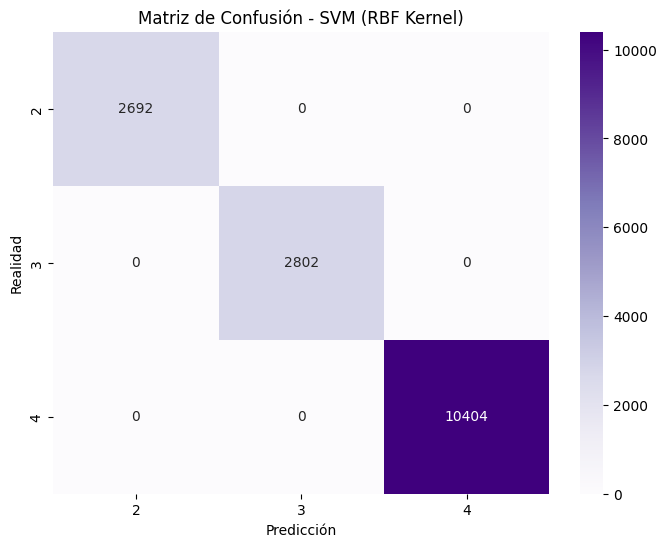

In [16]:
print("\nReporte de Clasificación:")
print(classification_report(y_test_s, y_pred_s))

# Matriz de Confusión Visual
plt.figure(figsize=(8, 6))
cm_svm = confusion_matrix(y_test_s, y_pred_s)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=sorted(df['Level_Num'].unique()), 
            yticklabels=sorted(df['Level_Num'].unique()))
plt.title('Matriz de Confusión - SVM (RBF Kernel)')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()